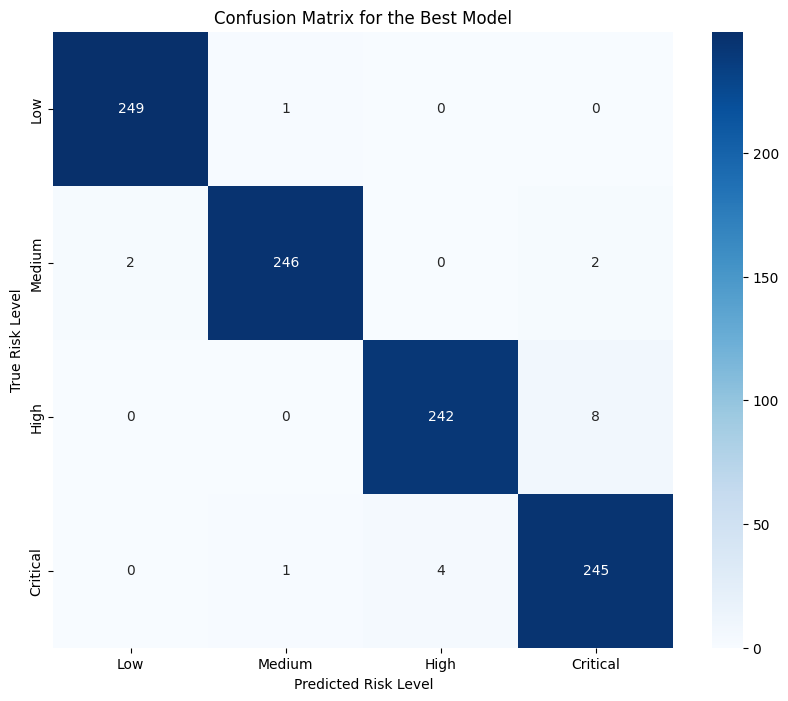


The best model is not a Random Forest, so direct feature importance is not available.


In [1]:
# rockfall-prediction-system/notebooks/04_results_visualization.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import confusion_matrix

# Load the best model and test data
model_path = '../models/best_model.pkl'
with open(model_path, 'rb') as f:
    best_model = pickle.load(f)

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Make predictions
y_pred = best_model.predict(X_test)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Low', 'Medium', 'High', 'Critical']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for the Best Model')
plt.xlabel('Predicted Risk Level')
plt.ylabel('True Risk Level')
plt.show()

# 2. Feature Importance Plot
if 'RandomForestClassifier' in str(best_model.named_steps['clf']):
    model = best_model.named_steps['clf']
    importances = model.feature_importances_
    feature_names = X_test.columns
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance for Rockfall Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Sensor Feature')
    plt.show()
else:
    print(f"\nThe best model is not a Random Forest, so direct feature importance is not available.")